<a href="https://colab.research.google.com/github/azzindani/00_Kaggle_Biomed_Dataset/blob/main/Prostate_Segmentation_Int_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuroimaging Informatics Technology Initiative (NIfTI) Viewer

## 00 Import Modules

In [ ]:
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
!pip install -q nilearn

import pathlib
import os
import nibabel as nib
import matplotlib.pyplot as plt
#import pydicom
import numpy as np
import cv2
import mediapy as media
import ipywidgets as widgets
#import screeninfo

from matplotlib.colors import ListedColormap
from ipywidgets import interact
from nilearn import plotting, image
from nilearn.image import load_img, new_img_like
from scipy.ndimage import zoom
from zipfile import ZipFile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 27.3 MB/s eta 0:00:00


## 01 Download Dataset

In [ ]:
url = 'https://www.kaggle.com/datasets/shrirangajaysonawane/prostate-dataset-mri-mask'
url_path = url.split('datasets/')[1]

!kaggle datasets download -d {url_path}

Dataset URL: https://www.kaggle.com/datasets/shrirangajaysonawane/prostate-dataset-mri-mask
License(s): unknown
 99% 1.50G/1.51G [00:21<00:00, 105MB/s]
100% 1.51G/1.51G [00:21<00:00, 76.6MB/s]


## 02 Extract Dataset

In [ ]:
zipfile = ZipFile(os.listdir()[1])
zipfile.extractall() #'''

## 03 Get File List

In [ ]:
root_dir = '/content/'
file_format = '.nii'
n = 5
file_paths = []

for root, dirs, files in os.walk(root_dir):
  for file in files:
    if file.endswith(file_format):
      file_paths.append(os.path.join(root, file))

    if len(file_paths) >= n:
      break
  if len(file_paths) >= n:
    break

file_paths

['/content/I2CVB/Case13_segmentation.nii',
 '/content/I2CVB/Case04.nii',
 '/content/I2CVB/Case16_segmentation.nii',
 '/content/I2CVB/Case08.nii',
 '/content/I2CVB/Case01.nii']

In [ ]:
volume_path = '/content/RUNMC/Case02.nii'
mask_path = '/content/RUNMC/Case02_segmentation.nii'

In [ ]:
compress = 3
stretch = 6

## 04 Preview NIfTI

### 04.01 Initial Preview

This is volume path : /content/RUNMC/Case02.nii
This is mask path : /content/RUNMC/Case02_segmentation.nii
Shape is (num_images, height, width, num_channels) = (24, 384, 384, 3).
Framerate is 10.0 frames/s.



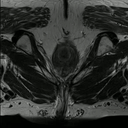

In [ ]:
def preview_video_nifti(volume_path, mask_path, compress = 2):
  volume_img = nib.load(volume_path)
  mask_img = nib.load(mask_path)

  volume_data = volume_img.get_fdata()
  mask_data = mask_img.get_fdata()

  if volume_data.ndim == 4:
    volume_data = volume_data[0, :, :, :]
  if mask_data.ndim == 4:
    mask_data = mask_data[0, :, :, :]

  # Normalize volume data
  volume_data = (volume_data - np.min(volume_data)) / (np.max(volume_data) - np.min(volume_data))

  # Resize mask data if shapes don't match
  if volume_data.shape != mask_data.shape:
    print(f"Resizing mask from {mask_data.shape} to {volume_data.shape}")
    scaling_factors = np.array(volume_data.shape) / np.array(mask_data.shape)
    mask_data = zoom(mask_data, scaling_factors, order = 0)

  height, width = volume_data.shape[:2]
  fps = 10
  output_video_path = root_dir + '/' + volume_path.split('/')[-1].split('.')[0] + '.mp4'
  volume_opacity = 1
  mask_opacity = 0.5

  fourcc = cv2.VideoWriter_fourcc(*'XVID')
  video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

  for i in range(volume_data.shape[2]):
    volume_slice = (volume_data[:, :, i] * 255).astype(np.uint8)
    mask_slice = (mask_data[:, :, i] > 0).astype(np.uint8)

    color_mask = np.zeros((height, width, 3), dtype = np.uint8)
    color_mask[mask_slice == 1] = [255, 0, 0]

    volume_colored = cv2.cvtColor(volume_slice, cv2.COLOR_GRAY2BGR)
    combined_frame = cv2.addWeighted(volume_colored, volume_opacity, color_mask, mask_opacity, 0)
    video_writer.write(combined_frame)

  video_writer.release()

  video = media.read_video(output_video_path)
  print('This is volume path :', volume_path)
  print('This is mask path :', mask_path)
  print(f'Shape is (num_images, height, width, num_channels) = {video.shape}.')
  if metadata := video.metadata:
    print(f'Framerate is {metadata.fps} frames/s.')
  video_rotated = np.array([np.rot90(frame) for frame in video])
  video2 = media.resize_video(video_rotated, tuple(np.array(video_rotated.shape[1:3]) // compress))
  return media.show_video(video2, fps = fps, codec = 'gif')

preview_video_nifti(volume_path, mask_path, compress = compress)

### 04.02 Interactive Plot Stat Map Preview

In [ ]:
def interactive_plot_stat_map(cut_coords):
  volume_img = load_img(volume_path)

  if len(volume_img.shape) == 4:
    volume_data = volume_img.slicer[0:1, :, :, :].get_fdata().squeeze()
    volume_img = new_img_like(volume_img, volume_data)

  plotting.plot_stat_map(volume_img, display_mode = 'z', cut_coords = cut_coords, title = 'Axial View', colorbar = True)
  plotting.plot_stat_map(volume_img, display_mode = 'y', cut_coords = cut_coords, title = 'Coronal View', colorbar = True)
  plotting.plot_stat_map(volume_img, display_mode = 'x', cut_coords = cut_coords, title = 'Sagittal View', colorbar = True)


cut_coord_slider = widgets.IntSlider(min = 1, max = 50, step = 1, value = 5, description = "Cut Coord")

interact(
  interactive_plot_stat_map,
  cut_coords = cut_coord_slider
)

### 04.03 Interactive Plot Epi Preview

In [ ]:
def interactive_plot_epi(cut_coords, colormap):
  volume_img = load_img(volume_path)

  if len(volume_img.shape) == 4:
    volume_data = volume_img.slicer[0:1, :, :, :].get_fdata().squeeze()
    volume_img = new_img_like(volume_img, volume_data)

  plotting.plot_epi(volume_img, display_mode = 'z', cut_coords = cut_coords, cmap = colormap, title = 'Axial View')
  plotting.plot_epi(volume_img, display_mode = 'y', cut_coords = cut_coords, cmap = colormap, title = 'Coronal View')
  plotting.plot_epi(volume_img, display_mode = 'x', cut_coords = cut_coords, cmap = colormap, title = 'Sagittal View')

  plotting.show()

cut_coord_slider1 = widgets.IntSlider(min = 1, max = 50, step = 1, value = 5, description = "Cut Coord")
colormap_dropdown1 = widgets.Dropdown(
  options = [
    'viridis', 'plasma', 'cividis', 'hot', 'coolwarm', 'gray',
    'magma', 'inferno', 'jet', 'rainbow', 'bone', 'pink', 'ocean',
    'spring', 'summer', 'autumn', 'winter', 'copper', 'twilight'
  ],
  value='gray',
  description='Colormap'
)

interact(
  interactive_plot_epi,
  cut_coords = cut_coord_slider1,
  colormap = colormap_dropdown1
)

### 04.04 Interactive Masked Preview

In [ ]:
def load_nifti(nifti_path):
  nifti_img = nib.load(nifti_path)
  nifti_data = nifti_img.get_fdata()
  if nifti_data.ndim == 4:
    nifti_data = nifti_data[0, :, :, :]
  return nifti_data

def plot_interactive_slices(slice_index, coronal_height, sagittal_height, colormap, vertical_scaling, mask_opacity, volume_intensity):
  volume_data = load_nifti(volume_path) * volume_intensity
  mask_data = load_nifti(mask_path)

  fig, axes = plt.subplots(1, 3, figsize = (18, 6))

  # Axial view
  axial_slice = volume_data[:, :, slice_index]
  mask_axial = mask_data[:, :, slice_index]
  axes[0].imshow(axial_slice.T, cmap = colormap, origin = 'lower')
  axes[0].imshow(mask_axial.T, cmap = 'gray', alpha = mask_opacity, origin = 'lower')
  axes[0].set_title(f"Axial View (Slice {slice_index})")
  axes[0].axis('off')

  # Coronal view
  coronal_slice = volume_data[:, coronal_height, :]
  mask_coronal = mask_data[:, coronal_height, :]
  axes[1].imshow(coronal_slice.T, cmap = colormap, origin = 'lower', aspect = 'auto')
  axes[1].imshow(mask_coronal.T, cmap = 'gray', alpha = mask_opacity, origin = 'lower')
  axes[1].set_title(f"Coronal View (Height {coronal_height})")
  axes[1].axis('off')
  # Apply vertical scaling for the coronal view
  axes[1].set_aspect(aspect = 'auto', adjustable = 'box')
  axes[1].set_aspect(1 * vertical_scaling)

  # Sagittal view
  sagittal_slice = volume_data[sagittal_height, :, :]
  mask_sagittal = mask_data[sagittal_height, :, :]
  axes[2].imshow(sagittal_slice.T, cmap = colormap, origin = 'lower', aspect = 'auto')
  axes[2].imshow(mask_sagittal.T, cmap = 'gray', alpha = mask_opacity, origin = 'lower')
  axes[2].set_title(f"Sagittal View (Height {sagittal_height})")
  axes[2].axis('off')
  # Apply vertical scaling for the sagittal view
  axes[2].set_aspect(aspect = 'auto', adjustable = 'box')
  axes[2].set_aspect(1 * vertical_scaling)

  plt.tight_layout()
  plt.show()

volume_data = load_nifti(volume_path)
slice_slider = widgets.IntSlider(value = volume_data.shape[2] // 2, min = 0, max = volume_data.shape[2] - 1, step = 1, description = 'Slice Index')
coronal_height_slider = widgets.IntSlider(value = volume_data.shape[1] // 2, min = 0, max = volume_data.shape[1] - 1, step = 1, description = 'Coronal Height')
sagittal_height_slider = widgets.IntSlider(value = volume_data.shape[0] // 2, min = 0, max = volume_data.shape[0] - 1, step = 1, description = 'Sagittal Height')

vertical_scaling_slider = widgets.FloatSlider(value = stretch, min = 0.2, max = 10.0, step = 0.1, description = 'Vertical Scaling')
mask_opacity_slider = widgets.FloatSlider(value = 0.5, min = 0.0, max = 1.0, step = 0.05, description = 'Mask Opacity')
volume_intensity_slider = widgets.FloatSlider(value = 1.0, min = 0.1, max = 3.0, step = 0.1, description = 'Volume Intensity')

colormap_dropdown2 = widgets.Dropdown(
  options = [
    'viridis', 'plasma', 'cividis', 'hot', 'coolwarm', 'gray',
    'magma', 'inferno', 'jet', 'rainbow', 'bone', 'pink', 'ocean',
    'spring', 'summer', 'autumn', 'winter', 'copper', 'twilight'
  ],
  value='gray',
  description='Colormap'
)

interact(
  plot_interactive_slices,
  slice_index = slice_slider,
  coronal_height = coronal_height_slider,
  sagittal_height = sagittal_height_slider,
  colormap = colormap_dropdown2,
  vertical_scaling = vertical_scaling_slider,
  mask_opacity = mask_opacity_slider,
  volume_intensity = volume_intensity_slider
)

### 04.05 Multi Angle Video Preview

This is the axial video for volume path: /content/RUNMC/Case02.nii
Framerate is 10.0 frames/s.



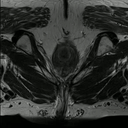

This is the coronal video for volume path: /content/RUNMC/Case02.nii
Framerate is 10.0 frames/s.



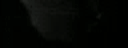

This is the sagittal video for volume path: /content/RUNMC/Case02.nii
Framerate is 10.0 frames/s.



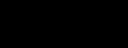

In [ ]:
def preview_nifti_views(volume_path, mask_path, compress = 2, stretch = 2.8):
  volume_data = load_nifti(volume_path)
  mask_data = load_nifti(mask_path)

  volume_data = (volume_data - np.min(volume_data)) / (np.max(volume_data) - np.min(volume_data))

  # Resize mask data if shapes don't match
  if volume_data.shape != mask_data.shape:
    print(f"Resizing mask from {mask_data.shape} to {volume_data.shape}")
    scaling_factors = np.array(volume_data.shape) / np.array(mask_data.shape)
    mask_data = zoom(mask_data, scaling_factors, order = 0)

  # Ensure mask is binary
  mask_data = (mask_data > 0).astype(np.uint8)

  height, width = volume_data.shape[:2]
  fps = 10
  volume_opacity = 1
  mask_opacity = 0.5
  fourcc = cv2.VideoWriter_fourcc(*'XVID')

  # Axial View
  create_video(volume_data, mask_data, axis = 2, fourcc = fourcc, fps = fps, compress = compress, stretch = stretch,
                volume_opacity = volume_opacity, mask_opacity = mask_opacity, view_name = 'axial', volume_path = volume_path)

  # Coronal View
  create_video(volume_data, mask_data, axis = 1, fourcc = fourcc, fps = fps, compress = compress, stretch = stretch,
                volume_opacity = volume_opacity, mask_opacity = mask_opacity, view_name = 'coronal', volume_path = volume_path)

  # Sagittal View
  create_video(volume_data, mask_data, axis = 0, fourcc = fourcc, fps = fps, compress = compress, stretch = stretch,
                volume_opacity = volume_opacity, mask_opacity = mask_opacity, view_name = 'sagittal', volume_path = volume_path)


def create_video(volume_data, mask_data, axis, fourcc, fps, compress, volume_opacity, mask_opacity, view_name, volume_path, stretch):
  if axis == 0:  # Sagittal
    height, width = volume_data.shape[1:]
  elif axis == 1:  # Coronal
    height, width = volume_data.shape[0], volume_data.shape[2]
  else:  # Axial
    height, width = volume_data.shape[:2]

  output_path = root_dir + '/' + volume_path.split('/')[-1].split('.')[0]
  video_writer = cv2.VideoWriter(f"{output_path}_{view_name}.mp4", fourcc, fps, (width, height))

  for i in range(volume_data.shape[axis]):
    if axis == 0:  # Sagittal
      volume_slice = (volume_data[i, :, :] * 255).astype(np.uint8)
      mask_slice = (mask_data[i, :, :] > 0).astype(np.uint8)
    elif axis == 1:  # Coronal
      volume_slice = (volume_data[:, i, :] * 255).astype(np.uint8)
      mask_slice = (mask_data[:, i, :] > 0).astype(np.uint8)
    else:  # Axial
      volume_slice = (volume_data[:, :, i] * 255).astype(np.uint8)
      mask_slice = (mask_data[:, :, i] > 0).astype(np.uint8)

    # Check slice shapes
    assert volume_slice.shape == mask_slice.shape, f"Mismatch in {view_name} slice shapes: {volume_slice.shape} vs {mask_slice.shape}"

    color_mask = np.zeros((height, width, 3), dtype = np.uint8)
    color_mask[mask_slice == 1] = [255, 0, 0]

    volume_colored = cv2.cvtColor(volume_slice, cv2.COLOR_GRAY2BGR)
    combined_frame = cv2.addWeighted(volume_colored, volume_opacity, color_mask, mask_opacity, 0)
    video_writer.write(combined_frame)

  video_writer.release()

  # Display video preview
  video = media.read_video(f"{output_path}_{view_name}.mp4")
  print(f"This is the {view_name} video for volume path: {volume_path}")
  #print(f"Shape is (num_images, height, width, num_channels) = {video.shape}.")
  if metadata := video.metadata:
    print(f"Framerate is {metadata.fps} frames/s.")
  video_rotated = np.array([np.rot90(frame) for frame in video])
  if axis in (0, 1):
    video_stretched = np.array([cv2.resize(frame, (frame.shape[1], int(frame.shape[0] * stretch))) for frame in video_rotated])
    video_resized = media.resize_video(video_rotated, tuple(np.array(video_stretched.shape[1:3]) // compress))

  else:
    video_resized = media.resize_video(video_rotated, tuple(np.array(video_rotated.shape[1:3]) // compress))
  media.show_video(video_resized, fps = fps, codec = 'gif')

preview_nifti_views(volume_path, mask_path, compress = compress, stretch = stretch)